In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [14]:
def f(x,a,b):
    """
    Linear function to fit.
    """
    return a*x+b

In [2]:
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = 10,7
plt.rcParams["figure.facecolor"] = "white"

In [3]:
df = pd.read_csv("../data/convergence_sigma_long.csv")

In [30]:
# creating unique ids for each community appending city id and community number
df["mgn_id"] = df["city"] + "_" + df["s_mgn"].map(str)
df["ms_id"] = df["city"] + "_" + df["s_ms"].map(str)

In [51]:
def get_coeff(l):
    """
    Given a list of values, and supposing that they are given for subsequent years,
    fit linear function on values and return slope and slope error.
    """
    p,pcov = curve_fit(f,range(len(l)),l)
    return p[0],np.sqrt(pcov[0,0])

In [32]:
# three different spatial aggregations
pairs = [
    ("county_id","cv_income_county"),
    ("mgn_id", "cv_income_mgn"),
    ("ms_id", "cv_income_ms")
]

In [81]:
results = {}

# threshold for the relative error on the slope
threshold = 0.05

for level,cv_col in pairs:
    # calculate slope for all units and store result in a dict
    # only store if the relative error of the fit of the slope is smaller than the threshold
    results[level] = df\
        .groupby([level,"year"])\
        [[cv_col]]\
        .first()\
        .dropna()\
        .reset_index()\
        .groupby([level])\
        [cv_col]\
        .agg(lambda x: list(x))\
        .map(lambda l: get_coeff(l)[0] if get_coeff(l)[1]/get_coeff(l)[0]<threshold else None)\
        .dropna()\
        .to_dict()

Text(0, 0.5, 'PDF of slopes')

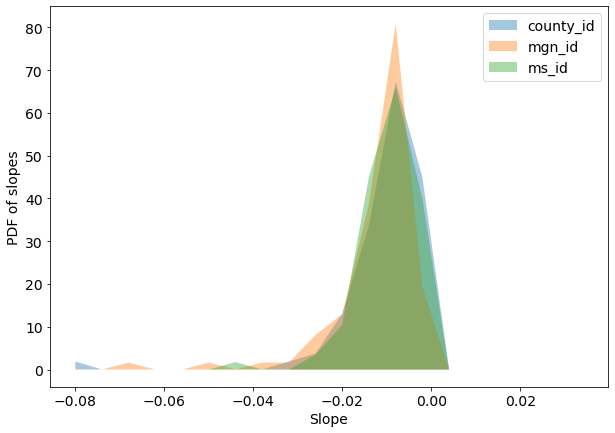

In [82]:
# plot distributions of slopes
plt.figure()
for level in results:
    y,x = np.histogram([v for k,v in results[level].items()],range=(-0.08,0.04),bins=20,density=True)
    plt.fill_between(x[:-1],y,label=level,lw=2,alpha=0.4)
plt.legend()
plt.xlabel("Slope")
plt.ylabel("PDF of slopes")

In [66]:
def plot_elem(index=0,pair_index=0):
    """
    Interactive plotting of the fits.
    Pair index selects which grouping to use.
    Index goes through unique counties / communities.
    """
    level, cv_col = pairs[pair_index]    
    temp = df\
        .groupby([level,"year"])\
        [[cv_col]]\
        .first()\
        .dropna()\
        .reset_index()\
        .groupby([level])\
        [[cv_col,"year"]]\
        .agg(lambda x: list(x)).iloc[index,:]
    plt.plot(temp["year"],temp[cv_col],'bo')
    p,pcov = curve_fit(f,temp["year"],temp[cv_col])
    plt.plot(temp["year"],f(np.array(temp["year"]),*p),'r-',lw=2)
    plt.title(level + " " + str(temp.name))
    plt.xlabel("Year")
    plt.ylabel(cv_col)

In [75]:
from ipywidgets import interactive,IntSlider

In [77]:
interactive(plot_elem,index=IntSlider(0,0,500),pair_index=[0,1,2])

interactive(children=(IntSlider(value=0, description='index', max=500), Dropdown(description='pair_index', opt…